In [1]:
%matplotlib inline

import json
import math
import pprint
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import *
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,r2_score, f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix

In [30]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Flatten, Bidirectional, Activation

In [3]:
forex = pd.read_csv('prep_forex.csv', header=[0,1], index_col=0)
index = pd.read_csv('prep_index.csv', header=[0,1,2], index_col=0)

In [42]:
cd_features = {"BDT": [None, "VND"], 
               "MNT": [None, "LKR"],
               ('PKR', 'Karachi 100'): [None, "INR", ('JPY', 'NIkkei 225')],
               ('LKR', 'CSE All-Share'): [None, "IDR", ('MNT', 'MNE Top 20')]}

feats = [('PKR', 'Karachi 100'), ('LKR', 'CSE All-Share'), "BDT", "MNT"]

In [36]:
forex_pairs = list(set([x[1] for x in forex.columns if x[0] == 'Close']))
index_pairs = list(set([(x[1], x[2]) for x in index.columns if x[0] == 'Close']))

scalers = [None, MinMaxScaler, MaxAbsScaler, StandardScaler, RobustScaler, Normalizer,
           QuantileTransformer, PowerTransformer, FunctionTransformer]

metric = 'Close'
metrics = ['Open', 'Close', 'Low', 'High', 'Volume']
# target = [metric]
features = ['Intraday_OC', 'Prev_close_open'] + [y+x for x in ['', '_Ret', '_MTD', '_YTD'] for y in metrics]# if (x+y) not in target]


In [6]:
def plot_results(y_true, y_pred, model):
    plot_df = pd.concat([pd.DataFrame(y_true), pd.DataFrame(y_pred)], axis=1, ignore_index=True)
    plt.figure()
    plt.plot(plot_df)
    plt.title("LSTM")

In [51]:
def split_scale(X, y, scaler):
    X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)
    if(scaler):
        scaler_X = scaler()
        if(scaler == scalers[-1]):
            scaler_X = scaler(np.log1p)
        scaler_X = scaler_X.fit(X_train)
        X_train = scaler_X.transform(X_train)
        X_test = scaler_X.transform(X_test)
    return(X_train, X_test, y_train, y_test)

In [8]:
def check_bins(real, pred):
    try:
        y_test = Binarizer().transform(pd.DataFrame(real).pct_change().dropna())
        y_pred = Binarizer().transform(pd.DataFrame(pred).pct_change().dropna())
    except:
        y_test = Binarizer().transform(pd.DataFrame(real))
        y_pred = Binarizer().transform(pd.DataFrame(pred))
    print(confusion_matrix(y_test, y_pred))
    return({"F1" :f1_score(y_test, y_pred, average='weighted'),
        "Precision": precision_score(y_test, y_pred, average='weighted'),
        "Recall": recall_score(y_test, y_pred, average='weighted')})

In [19]:
def save_to_csv(real, pred, extra_feat, is_exog):
    save_data = pd.DataFrame(columns = ['y_true_class', 'y_pred_class', 'y_true_reg', 'y_pred_reg'], index = real.index)
    save_data['y_true_reg'] = real.values
    save_data['y_pred_reg'] = pred
    if(metric[-3:] == 'Ret'):
        save_data['y_true_class'] = np.sign(save_data['y_true_reg'])
        save_data['y_pred_class'] = np.sign(save_data['y_pred_reg'])
    else:
        save_data['y_true_class'] = np.sign(save_data['y_true_reg'].pct_change())
        save_data['y_pred_class'] = np.sign(save_data['y_pred_reg'].pct_change())
    try:
        save_data.to_csv(real.columns[0][1]+"_"+real.columns[0][0]+"_"+str(extra_feat)+"_"+str(is_exog)+"_LSTM.csv")
    except:
        save_data.to_csv(real.columns[0][1]+"_"+real.columns[0][0]+"_"+str(is_exog)+"_LSTM.csv")

In [10]:
def add_cross_domain_features(feat):
    if(isinstance(feat, tuple)):
        index_cols = index_cols = [x for x in index.columns if x[1] == feat[0] and x[2] == feat[1]]
        X = index[[col for col in index_cols if col[0] in features + ['Time features']]][:-1]
    else:
        forex_cols = [x for x in forex.columns if x[1] == feat]
        X = forex[[col for col in forex_cols if col[0] in features + ['Time features']]][:-1]
    return(X)

In [52]:
def do_forex_lstm(cur, target, extra_feat, is_exog=False, transf = None):
    forex_cols = [x for x in forex.columns if x[1] == cur]
    X = forex[[col for col in forex_cols if col[0] in features + ['Time features']]][:-1]
    y = forex[[col for col in forex_cols if col[0] == metric]].shift(-1)[:-1]
    if(extra_feat):
            X = X.join(add_cross_domain_features(extra_feat))
    X = X.dropna(how='all', axis=1)
    X = X.dropna(how='any')
    y = y[y.index.isin(X.index)]
    X_train, X_test, y_train, y_test = split_scale(X, y, transf)
    res, y_pred = run_lstm_model((X_train, y_train), (X_test, y_test), is_exog)
    save_to_csv(y_test, y_pred, extra_feat, is_exog)
    metrics = check_bins(y_test, y_pred)
    res.update(metrics)
    return(res)

def do_index_lstm(cur, target, extra_feat, is_exog=False, transf = None):
    index_cols = [x for x in index.columns if x[1] == cur[0] and x[2] == cur[1]]
    X = index[[col for col in index_cols if col[0] in features + ['Time features']]][:-1]
    y = index[[col for col in index_cols if col[0] == metric]].shift(-1)[:-1]
    if(extra_feat):
            X = X.join(add_cross_domain_features(extra_feat))
    X = X.dropna(how='all', axis=1)
    X = X.dropna(how='any')
    y = y[y.index.isin(X.index)]
    print(X)
    print(y)
    X_train, X_test, y_train, y_test = split_scale(X, y, transf)
    res, y_pred = run_lstm_model((X_train, y_train), (X_test, y_test), is_exog)
    save_to_csv(y_test, y_pred, extra_feat, is_exog)
    metrics = check_bins(y_test, y_pred)
    return(res.update(metrics))


In [34]:
def run_lstm_model(train, test, is_exog=False):
    train_X, train_y = train
    test_X, test_y = test
    if(not is_exog):
        X_train = None
    train_X = train_X.values.reshape((train_X.shape[0], 1, train_X.shape[1]))
    test_X = test_X.values.reshape((test_X.shape[0], 1, test_X.shape[1]))
    print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
    model = Sequential()
    model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True))
#     model.add(LSTM(100))
    model.add(Dense(100))
#     model.add(Dense(50))
    model.add(Flatten())
    model.add(Dense(1))
#     model.add(Activation('softmax'))
    model.compile(loss='mse', optimizer='adam')
    history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
    # plot history
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.legend()
    plt.show()
    yhat = model.predict(test_X)
    test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
    # invert scaling for forecast
    yhat = yhat[:,0]
    # invert scaling for actual
    test_y = test_y.values.reshape((len(test_y), 1))
    test_y = test_y[:,0]
    # calculate RMSE
    rmse = np.sqrt(mean_squared_error(test_y, yhat))
    print('Test RMSE: %.3f' % rmse)
    print('Test R2: %.3f' % r2_score(test_y, yhat))
    plot_results(test_y, yhat, model)
    return({}, yhat)

                 Close        High         Low        Open       Volume  \
Currency           PKR         PKR         PKR         PKR          PKR   
Idx        Karachi 100 Karachi 100 Karachi 100 Karachi 100  Karachi 100   
Date                                                                      
2013-11-06   23165.210   23218.720   22802.580    22802.58  132131000.0   
2013-11-07   23220.210   23350.130   23113.890    23224.92  120205000.0   
2013-11-08   23367.150   23392.110   23152.990    23208.79   98147000.0   
2013-11-11   23381.080   23588.520   23364.480    23371.83  158192000.0   
2013-11-12   23302.460   23530.760   23274.770    23385.03  129138000.0   
2013-11-13   23287.060   23312.650   23146.830    23276.92   91585000.0   
2013-11-14   23351.896   23385.182   23179.998    23284.07  100347001.6   
2013-11-15   23416.732   23457.714   23213.166    23291.22  109109003.2   
2013-11-18   23611.240   23675.310   23312.670    23312.67  135395008.0   
2013-11-19   23819.430   

Train on 1196 samples, validate on 300 samples
Epoch 1/50
 - 7s - loss: nan - val_loss: nan
Epoch 2/50
 - 0s - loss: nan - val_loss: nan
Epoch 3/50
 - 0s - loss: nan - val_loss: nan
Epoch 4/50
 - 0s - loss: nan - val_loss: nan
Epoch 5/50
 - 0s - loss: nan - val_loss: nan
Epoch 6/50
 - 0s - loss: nan - val_loss: nan
Epoch 7/50
 - 0s - loss: nan - val_loss: nan
Epoch 8/50
 - 0s - loss: nan - val_loss: nan
Epoch 9/50
 - 0s - loss: nan - val_loss: nan
Epoch 10/50
 - 0s - loss: nan - val_loss: nan
Epoch 11/50
 - 0s - loss: nan - val_loss: nan
Epoch 12/50
 - 0s - loss: nan - val_loss: nan
Epoch 13/50
 - 0s - loss: nan - val_loss: nan
Epoch 14/50
 - 0s - loss: nan - val_loss: nan
Epoch 15/50
 - 0s - loss: nan - val_loss: nan
Epoch 16/50
 - 0s - loss: nan - val_loss: nan
Epoch 17/50
 - 0s - loss: nan - val_loss: nan
Epoch 18/50
 - 0s - loss: nan - val_loss: nan
Epoch 19/50
 - 0s - loss: nan - val_loss: nan
Epoch 20/50
 - 0s - loss: nan - val_loss: nan
Epoch 21/50
 - 0s - loss: nan - val_loss: 

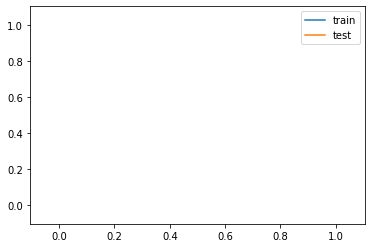

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [54]:
for cur in feats:
    for extra_feat in cd_features[cur]:
        for is_exog in [True, False]:
            do_index_lstm(cur, metric, extra_feat, is_exog=is_exog)